In [9]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

In [10]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load data

In [11]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [12]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [13]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [15]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


In [16]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1.21e-6
l1_ratio_reg = 0.394

lr = 0.00193
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 10
num_layers = 1
#input_size = 31 Not for now, only if I need a linear layer before the RNN

#Other training hyperparameters
lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25

Reg = globals().get(Regularizer_RNN)

**RNN Parameters**

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional RNN. Default: False

In [17]:
#model = CausalRNN(input_size= num_features, hidden_size = hidden_units, num_layers= num_layers, output_dim=num_dim_output, dropout= 0.3)

In [20]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 10
input_rec = 40
seq_length_LSTM = 10

model = SimpleRNN(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = False).to(device) 
#Here we use no_weights = False to try to train the model only on baseline data

Creating a simple RNN with 7233 weights.


In [21]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.1202 Val 0.0535
Epoch 001 Train 0.0164 Val 0.0259
Epoch 002 Train 0.0092 Val 0.0254
Epoch 003 Train 0.0068 Val 0.0236
Epoch 004 Train 0.0048 Val 0.0265
Epoch 005 Train 0.0038 Val 0.0242
Epoch 006 Train 0.0030 Val 0.0251
Epoch 007 Train 0.0023 Val 0.0242
Epoch 008 Train 0.0019 Val 0.0239
Epoch 009 Train 0.0018 Val 0.0248
Epoch 010 Train 0.0015 Val 0.0250
Epoch 011 Train 0.0012 Val 0.0236
Epoch 012 Train 0.0011 Val 0.0232
Epoch 013 Train 0.0009 Val 0.0235
Epoch 014 Train 0.0008 Val 0.0247
Epoch 015 Train 0.0007 Val 0.0222
Epoch 016 Train 0.0006 Val 0.0222
Epoch 017 Train 0.0005 Val 0.0240
Epoch 018 Train 0.0005 Val 0.0231
Epoch 019 Train 0.0005 Val 0.0240
Decrease LR
Epoch 020 Train 0.0005 Val 0.0238
Epoch 021 Train 0.0003 Val 0.0225
Epoch 022 Train 0.0003 Val 0.0227
Epoch 023 Train 0.0003 Val 0.0231
Epoch 024 Train 0.0003 Val 0.0223
Epoch 025 Train 0.0003 Val 0.0222
Epoch 026 Train 0.0003 Val 0.0225
Epoch 027 Train 0.0002 Val 0.0245
Epoch 028 Train 0.0002 Val 0.0232
Ep

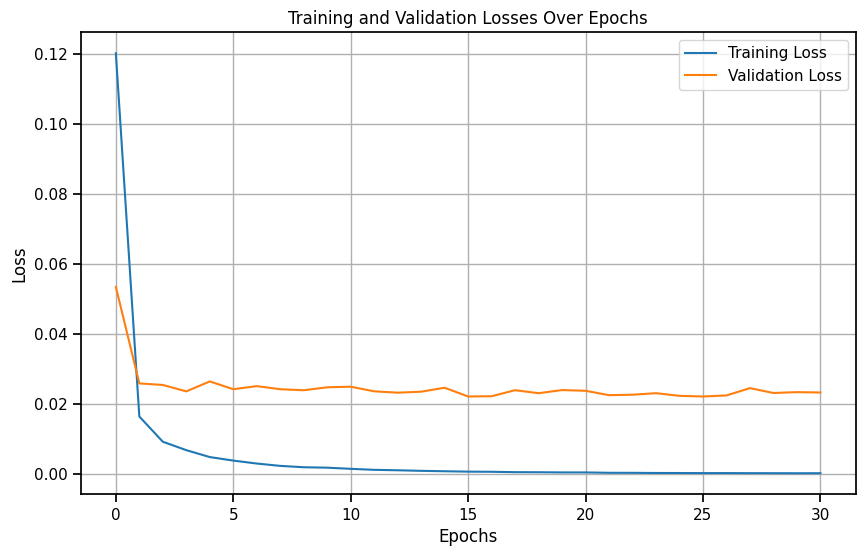

In [22]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [23]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.97 
Val EV: 0.43 
Test EV: 0.41 


## CL with Hypernetworks

Tutorial on the use of the hypnettorch package: https://github.com/chrhenning/hypnettorch/blob/master/hypnettorch/tutorials/getting_started.ipynb


From hypnettorch, we have:

- `SimpleRNN:` model which works as main networks and which has already the option or passing weights generated by other network in the forward loop.
    
- `HMLP:` A variety of hypernetworks is available in subpackage hypnettorch.hnets. The simplest being a fully-connected hypernetwork, see class hypnettorch.hnets.HMLP. Such simplistic hypernetwork is huge, as its parameter count is quadratic in the number of parameters of the corresponding main network. Therefore, several more sophisticated hypernetwork options are available, which are just as simple to use (most notably, hypnettorch.hnets.ChunkedHMLP). However, to keep this tutorial light, we don't discuss these options here.

In [24]:
from IPython.display import display, Markdown, Latex

In [25]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 10
input_rec = 40
seq_length_LSTM = 10


model = SimpleRNN(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = True).to(device) 
# Here no_weight set to true for the model to take the weights generated with the hypernetwork

Creating a simple RNN with 7233 weights.


Hypernetworks usually distinguish between two types of inputs: *conditional* and *unconditional* inputs. Conditional inputs are simply inputs that can be related to a finite and discrete set of conditions, such as the [task identity in continual learning](https://arxiv.org/abs/1906.00695). Simply speaking, conditional inputs can be used if the number $N$ of conditions is known a priori. In this case, the hypernetwork will create a set of $N$ learnable condition vectors (e.g., task embeddings), and can take the condition ID (as integer) as input to the ``forward`` method. This simplifies many usage scenarios, as the user of a hypernetwork does not have to maintain learnable input embeddings to the hypernetwork by himself. In all other cases (like the input to the hypernetwork comes from a continuous vector space), *unconditional* inputs should be used.

In our case, the hypernetwork should either generate a set of weights for MNIST (condition $0$) or FashionMNIST (condition $1$). Each of these conditions should internally be represented by a $8$-dimensional embedding vector.

In [26]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(model.param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[100, 100], 
            num_cond_embs=num_conditions).to(device)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

Created MLP Hypernet.
Hypernetwork with 741549 weights and 7233 outputs (compression ratio: 102.52).
The network consists of 741533 unconditional weights (741533 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([-0.2555, -0.3931, -0.0197,  0.3334,  1.0714, -0.1550,  1.1387, -0.9372],
       requires_grad=True), Parameter containing:
tensor([-0.9347,  1.1392, -0.1987,  0.8351,  0.7114,  0.2786,  0.0763,  1.0908],
       requires_grad=True)]


**Hypernetwork initialization** 
can be an important factor, for instance, [when using optimizers such as SGD](https://openreview.net/forum?id=H1lma24tPB). 

Therefore, some hypernet implementations provide custom initialization functions.

In [27]:
hnet.apply_hyperfan_init(mnet=model)

**Making predictions** with the target network is fairly easy. Simply generate the corresponding weights with the hypernetwork and pass them to the ``forward`` method of the main network together with the network inputs. 

In [28]:
from torch.utils.data import Dataset

In [29]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [30]:
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [32]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


In [33]:
num_epochs = 50

In [38]:
def train_hypernet(model, hnet,y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=10,
                batch_size_train = 3,
                batch_size_val = 3,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                ):

    # Initialize the hypernetwork
    hnet.apply_hyperfan_init(mnet=model)

    # Set up the optimizer with the specified learning rate
    optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset_baseline = SequenceDataset(
    y_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)

    train_dataset_stim = SequenceDataset(
    y_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)

    val_dataset_baseline = SequenceDataset(
    y_val_base,    x_val_base,    sequence_length=sequence_length_LSTM)

    val_dataset_stim = SequenceDataset(
    y_val_stim,    x_val_stim,    sequence_length=sequence_length_LSTM)

    loader_train_b = data.DataLoader(train_dataset_baseline, batch_size=batch_size_train, shuffle=True)
    loader_train_s = data.DataLoader(train_dataset_stim, batch_size=batch_size_train, shuffle=True)

    loader_val_b = data.DataLoader(val_dataset_baseline, batch_size=batch_size_val, shuffle=True)
    loader_val_s = data.DataLoader(val_dataset_stim, batch_size=batch_size_val, shuffle=True)

    


    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loaders = zip(loader_train_b, loader_train_s)
            else:
                model.eval()
                loaders = zip(loader_val_b, loader_val_s)

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for data_b, data_s in loaders:

                # Define data for this batch
                x_b = data_b[0]
                y_b = data_b[1]
                x_s = data_s[0]
                y_s = data_s[1]

                
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)
                        base_P = model.forward(x_b, weights=W_base)
                        base_P = torch.squeeze(base_P) # torch.sigmoid(base_P))
                        loss_base = huber_loss(base_P, y_b, delta = delta)
   
                        
                        # Compute STIMULATION loss.
                        W_stim = hnet(cond_id=1)
                        stim_P = model.forward(x_s, weights=W_stim)
                        stim_P = torch.squeeze(stim_P) #torch.sigmoid(stim_P))
                        loss_stim = huber_loss(stim_P, y_s, delta = delta)


                        # Combine loss for 2 tasks
                        loss_t = loss_base + loss_stim
                        
                        # Add regularization to the loss in the training phase
                        """ if regularizer is not None:
                            loss_t += regularizer(model, l1_ratio, alpha) """
                        # Compute gradients and perform an optimization step
                        loss_t.backward()
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    W_base = hnet(cond_id=0)
                    base_P = model.forward(x_b, weights=W_base)
                    base_P = torch.squeeze(base_P) #torch.sigmoid(base_P))
                    loss_base = huber_loss(base_P, y_b, delta = delta)

                    W_stim = hnet(cond_id=1)
                    stim_P = model.forward(x_s, weights=W_stim)
                    stim_P = torch.squeeze(stim_P) #torch.sigmoid(stim_P))
                    loss_stim = huber_loss(stim_P, y_s, delta = delta)

                    loss_t = loss_base + loss_stim

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [39]:
train_losses, val_losses = train_hypernet(model, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=10,
                batch_size_train = 3,
                batch_size_val = 3,
                num_epochs=1000)

Epoch 000 Train 0.0921 Val 0.0502
Epoch 001 Train 0.0056 Val 0.0470
Epoch 002 Train 0.0024 Val 0.0444
